In [1]:
import os 
directory_changed = False 
try:
    from simulations.inhomogeneous import simulate_inhomogeneous_record
except:
    print("Adjusting path for imports..")
    os.chdir("..")
    directory_changed = True
    from simulations.inhomogeneous import simulate_inhomogeneous_record

import results
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import csv
from pathlib import Path
from datetime import datetime
print(os.getcwd())
from scriptss.parallel_sims_rq3 import worker
import numpy as np
import re
import matplotlib.pyplot as plt


Adjusting path for imports..
c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19


In [ ]:
base_dir = Path.cwd() / "data" / "inhomogeneous_experiment"
base_dir.mkdir(parents=True, exist_ok=True)

# make a new experiment directory
idx = 1
while (base_dir / f"experiment_{idx}").exists():
    idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True, exist_ok=False)
print(f" Results are stored in: {outdir}")

In [3]:

# Parameters
L = 256         # grid size
p = 0.01       # tree growth probability
f = 0.0001     # lightning probability
steps = 1000        # simulation steps  
runs_per_param = 5 # amount of runs per parameter setting

#define oak ratios to test
# we test with 0%, 20%, 40%, 60%, 80% and 100% oak trees
oak_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
p_burn_oak = 0.3   # oaks have a fixed burn probability of 0.3

# build parameter list
param_list = []
param_idx = 1

# we keep a map of parameter index to oak ratio for later analysis
param_map = {} 

for ratio in oak_ratios:
    param_map[param_idx] = ratio 
    
    for run_idx in range(runs_per_param):
        param_list.append({
            'L': L, 'p': p, 'f': f, 'steps': steps,
            'oak_ratio': ratio,
            'p_burn_oak': p_burn_oak,
            'param_id': param_idx,
            'run_id': run_idx
        })
    param_idx += 1

print(f" Ready to {len(param_list)} simulations.")
print(f"Variable Oak Ratios: {oak_ratios}")

 Ready to 30 simulations.
Variable Oak Ratios: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


In [4]:
max_workers = multiprocessing.cpu_count()
print(f"Start with {max_workers} processors...")

results = []
with ProcessPoolExecutor(max_workers=max_workers) as exe:
    # Start alle taken
    futures = {exe.submit(worker, outdir, params): params for params in param_list}
    
    for fut in as_completed(futures):
        params = futures[fut]
        try:
            res = fut.result()
            # Print status update
            ratio = params['oak_ratio']
            print(f"✅ Klaar: Oak Ratio={ratio:.1f}, Run={params['run_id']} -> Gem. Brandgrootte={res['mean_size']:.2f}")
            results.append(res)
        except Exception as e:
            print(f"Error at params {params}: {e}")

print("Simulations finished!")

Start with 8 processors...
✅ Klaar: Oak Ratio=0.0, Run=4 -> Gem. Brandgrootte=160.59
✅ Klaar: Oak Ratio=0.0, Run=1 -> Gem. Brandgrootte=159.91
✅ Klaar: Oak Ratio=0.0, Run=0 -> Gem. Brandgrootte=157.28
✅ Klaar: Oak Ratio=0.0, Run=3 -> Gem. Brandgrootte=155.78
✅ Klaar: Oak Ratio=0.0, Run=2 -> Gem. Brandgrootte=158.73
✅ Klaar: Oak Ratio=0.2, Run=2 -> Gem. Brandgrootte=98.04
✅ Klaar: Oak Ratio=0.2, Run=1 -> Gem. Brandgrootte=96.19
✅ Klaar: Oak Ratio=0.2, Run=0 -> Gem. Brandgrootte=92.39
✅ Klaar: Oak Ratio=0.2, Run=3 -> Gem. Brandgrootte=95.70
✅ Klaar: Oak Ratio=0.2, Run=4 -> Gem. Brandgrootte=95.47
✅ Klaar: Oak Ratio=0.4, Run=0 -> Gem. Brandgrootte=53.20
✅ Klaar: Oak Ratio=0.4, Run=1 -> Gem. Brandgrootte=51.04
✅ Klaar: Oak Ratio=0.4, Run=2 -> Gem. Brandgrootte=52.34
✅ Klaar: Oak Ratio=0.4, Run=4 -> Gem. Brandgrootte=51.95
✅ Klaar: Oak Ratio=0.4, Run=3 -> Gem. Brandgrootte=52.82
✅ Klaar: Oak Ratio=0.6, Run=0 -> Gem. Brandgrootte=26.23
✅ Klaar: Oak Ratio=0.6, Run=2 -> Gem. Brandgrootte=26.10

In [5]:
# Zoek alle perstep files in de output map
perstep_files = sorted(outdir.glob('perstep_*.csv'))
print(f"Found Files: {len(perstep_files)}")

# Regex om param_id uit bestandsnaam te halen
pattern = re.compile(r'perstep_param(?P<param>\d+)_')

data_by_ratio = {} # Hier slaan we alles op: { 0.2: [run1_data, run2_data], ... }

for fp in perstep_files:
    # 1. Welke param_id is dit?
    match = pattern.search(fp.name)
    if not match: continue
    pid = int(match.group('param'))
    
    # 2. Welke Oak Ratio hoort daarbij?
    ratio = param_map.get(pid)
    if ratio is None: continue
    
    # 3. Lees bestand in
    densities = []
    with open(fp, 'r') as f:
        reader = csv.reader(f)
        next(reader) # Skip header
        for row in reader:
            # Kolom 3 is 'mean tree density' (zie worker script)
            if row[3]:
                densities.append(float(row[3]))
                
    # 4. Opslaan
    if ratio not in data_by_ratio:
        data_by_ratio[ratio] = []
    data_by_ratio[ratio].append(np.array(densities))

print("Data loaded and sorted by Oak Ratio.")

Found Files: 30
Data loaded and sorted by Oak Ratio.


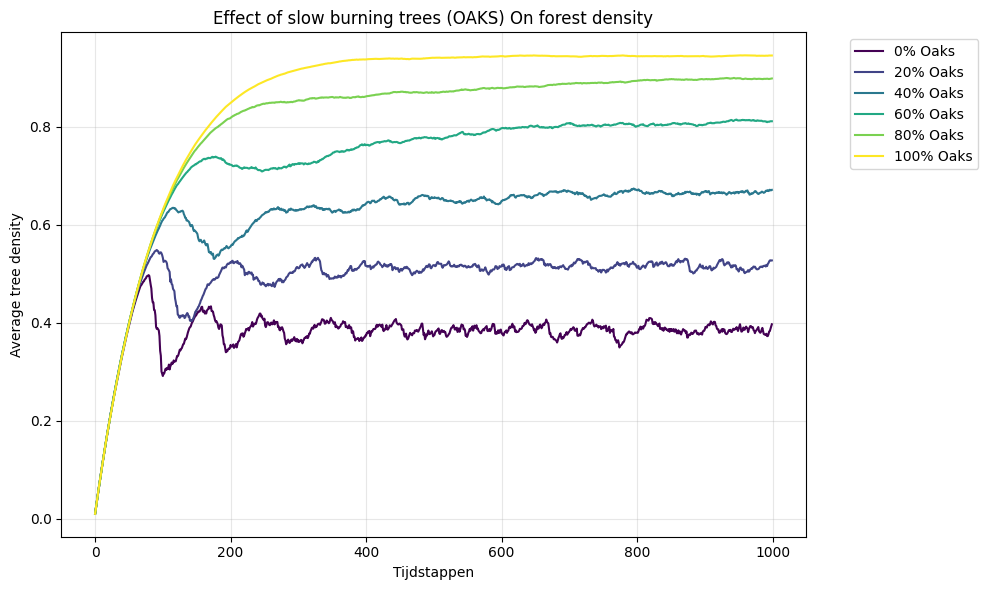

In [6]:
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(data_by_ratio)))

for idx, (ratio, runs) in enumerate(sorted(data_by_ratio.items())):
    # Pak het gemiddelde van alle 5 runs voor deze ratio
    # We moeten zorgen dat ze even lang zijn (voor het geval eentje eerder stopte)
    min_len = min(len(r) for r in runs)
    truncated_runs = [r[:min_len] for r in runs]
    
    mean_density = np.mean(truncated_runs, axis=0)
    
    # Plot alleen de laatste 1000 stappen (om de opstart-fase over te slaan)
    # Of plot alles als je wilt.
    plt.plot(mean_density, label=f'{int(ratio*100)}% Oaks', color=colors[idx], linewidth=1.5)

plt.xlabel('Tijdstappen')
plt.ylabel('Average tree density')
plt.title('Effect of slow burning trees (OAKS) On forest density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()